In [3]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from tensorboardX import SummaryWriter
from tqdm import tqdm
import gc
from copy import deepcopy
from gym_dubins_car import DubinsCarEnv

import torch
import numpy as np
from torch import nn
import math
from models import *   
from train_dubins_no_obstacle import *
from core import generate_default_model_name

import scipy
from random import shuffle
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from collections import defaultdict

# inference

In [2]:
Env = DubinsCarEnv
env = DubinsCarEnv(num_agents=3, mode='barrier', PROB=(0,0.1), SIZE=(8,8))
name_dict = generate_default_model_name(Env)
bnn = OriginGNNv3(HIDDEN_SIZE, keys=['agent'])
bnn.to(device)
bnn.load_state_dict(torch.load('model_gnn/dbgnn_DubinsCarEnv13199_0.00.pt', map_location=device))
'model_gnn/dbgnn_DubinsCarEnv13199_0.00.pt'
name_dict['db']
bnn.eval()

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


OriginGNNv3(
  (embed): ModuleDict(
    (agent): LazyLinear(in_features=0, out_features=128, bias=True)
  )
  (edge_embed): ModuleDict(
    (('agent', 'a_near_a', 'agent')): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (convs): ModuleList(
    (0): HeteroConv(num_relations=1)
    (1): HeteroConv(num_relations=1)
    (2): HeteroConv(num_relations=1)
  )
  (field): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [28]:
Env = DubinsCarEnv
env = DubinsCarEnv(num_agents=3, mode='barrier', PROB=(0,0.1), SIZE=(8,8))
name_dict = generate_default_model_name(Env)
bnn = OriginGNNv3(HIDDEN_SIZE, keys=['agent', 'obstacle'])
bnn.to(device)
bnn.load_state_dict(torch.load('model_gnn/dbgnn_DubinsCarEnv_v5.pt', map_location=device))
bnn.eval()

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch_geometric/nn/conv/hetero_conv.py:53: UserWarning: There exist node types ({'obstacle'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


OriginGNNv3(
  (embed): ModuleDict(
    (agent): LazyLinear(in_features=0, out_features=128, bias=True)
    (obstacle): LazyLinear(in_features=0, out_features=128, bias=True)
  )
  (edge_embed): ModuleDict(
    (('obstacle', 'o_near_a', 'agent')): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (('agent', 'a_near_a', 'agent')): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (convs): ModuleList(
    (0): HeteroConv(num_relations=2)
    (1): HeteroConv(num_relations=2)
    (2): HeteroConv(num_relations=2)
  )
  (field): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [3]:
NUM_AGENTS, OBSTACLE_DENSITY, MAP_SIZE = 1, 0, 3

valid_dataset = []
for _ in range(20):
    while True:
        env = DubinsCarEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
        if (np.linalg.norm(env.world.agents - env.world.agent_goals, axis=-1).min() >= 2):
            break
    valid_dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

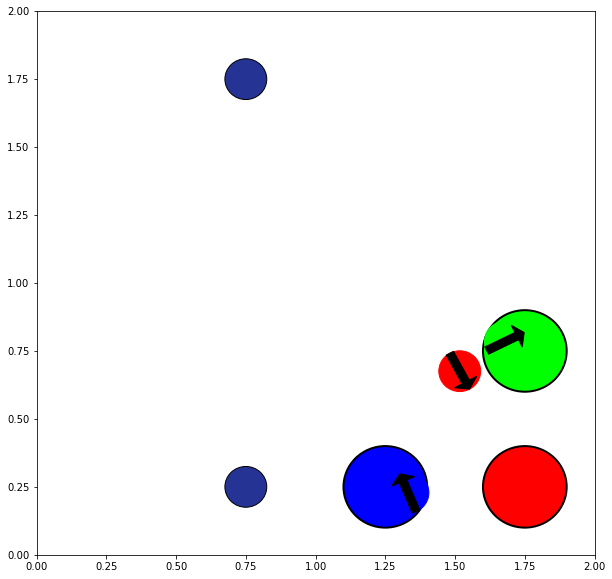

In [19]:
for v_idx, data in enumerate(valid_dataset):
    env = Env(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    collided, done, gifs = infer(env, bnn)
    save_gif(gifs, 'gifs/'+'Dubins_test_'+str(v_idx)+'_'+str(np.any(collided))+'.gif')

[0.15178934 0.1517882  0.1401518 ] [0.15561616 0.15557007 0.16277193] [0.15309718 0.15554918 0.1401518 ] [False False False]
[0.16737275 0.14677408 0.15652806] [0.17244847 0.1498557  0.17716977] [0.16896027 0.14859489 0.15658124] [False False False]
[0.18778569 0.17627437 0.11692185] [0.19418997 0.18853462 0.1347879 ] [0.19040772 0.17746493 0.12066081] [False False False]
[0.1981631  0.17613557 0.12026411] [0.21541347 0.1880622  0.1333351 ] [0.19816491 0.17826024 0.128748  ] [False False False]
[0.19017576 0.17477746 0.11594837] [0.22573175 0.18776906 0.1290063 ] [0.20170777 0.1773749  0.12524614] [False False False]
[0.18991798 0.17356856 0.11184943] [0.2258019  0.18799987 0.1250218 ] [0.20225476 0.17636523 0.12199304] [False False False]
[0.18991368 0.16108713 0.10839238] [0.22577664 0.17280523 0.12173381] [0.2022488  0.16398616 0.11842127] [False False False]
[0.18699819 0.15882668 0.10470151] [0.19406651 0.17065467 0.11805793] [0.19287704 0.16180433 0.11498752] [False False False]


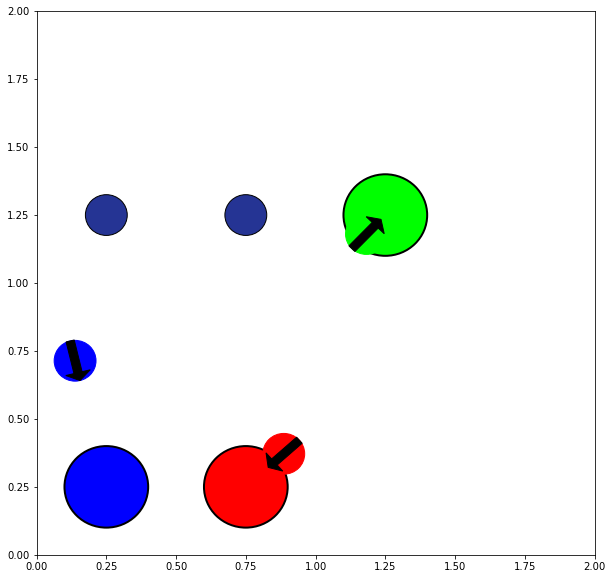

In [22]:
data = valid_dataset[18]
env = Env(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
collided, done, gifs = infer(env, bnn, verbose=True)

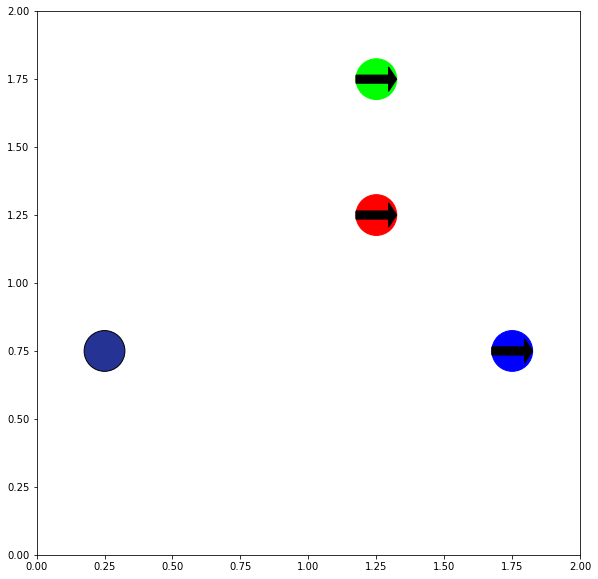

In [3]:
%notebook widget
import matplotlib.pyplot as plt
env = DubinsCarEnv(num_agents=3, mode='barrier', PROB=(0,0.1), SIZE=(4,4))
plt.imshow(env._render())
plt.show()

In [4]:
env._get_obs(mode='barrier')

HeteroData(
  agent={ x=[3, 1] },
  obstacle={ x=[1, 1] },
  goal={ x=[3, 1] },
  (agent, a_near_a, agent)={
    edge_index=[2, 6],
    edge_attr=[6, 2]
  },
  (obstacle, o_near_a, agent)={
    edge_index=[2, 0],
    edge_attr=[0, 2]
  },
  (goal, toward, agent)={
    edge_index=[2, 3],
    edge_attr=[3, 2]
  }
)

# inference with obstacles

In [25]:
from tensorboardX import SummaryWriter
from tqdm import tqdm
import gc
from copy import deepcopy
from gym_dubins_car import DubinsCarEnv

import torch
import numpy as np
from torch import nn
import math
from models import *   
from train_dubins_no_obstacle import *
from core import generate_default_model_name

import scipy
from random import shuffle
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from collections import defaultdict

In [5]:
Env = DubinsCarEnv
env = DubinsCarEnv(num_agents=3, mode='barrier', PROB=(0,0.1), SIZE=(8,8))
name_dict = generate_default_model_name(Env)
bnn = OriginGNNv3(HIDDEN_SIZE, keys=['agent'])
bnn.to(device)
bnn.load_state_dict(torch.load('model_gnn/good_models/dbgnn_DubinsCarEnv.pt', map_location=device))
bnn.eval()

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


OriginGNNv3(
  (embed): ModuleDict(
    (agent): LazyLinear(in_features=0, out_features=128, bias=True)
  )
  (edge_embed): ModuleDict(
    (('agent', 'a_near_a', 'agent')): Sequential(
      (0): LazyLinear(in_features=0, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (convs): ModuleList(
    (0): HeteroConv(num_relations=1)
    (1): HeteroConv(num_relations=1)
    (2): HeteroConv(num_relations=1)
  )
  (field): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [4]:
%env CUDA_LAUNCH_BLOCKING=1
NUM_AGENTS, OBSTACLE_DENSITY, MAP_SIZE = 30, 0, 7

env: CUDA_LAUNCH_BLOCKING=1


In [5]:
Env = DubinsCarEnv
valid_dataset = []
for _ in range(20):
    while True:
        env = Env(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
        if (np.linalg.norm(env.world.agents - env.world.agent_goals, axis=-1).min() >= 2):
            break
    valid_dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

In [6]:
# from train_dubins_no_obstacle import *
# bnn.load_state_dict(torch.load('model_gnn/good_models/dbgnn_DubinsCarEnv18299_0.00.pt', map_location=device)) # (0.02 1.0 55.08)
# bnn.load_state_dict(torch.load('model_gnn/good_models/dbgnn_DubinsCarEnv.pt', map_location=device))  # (0.02 1.0 54.29)



from train_dubins_no_obstacle_v3 import *
bnn.load_state_dict(torch.load('model_gnn/good_models/dbgnn_DubinsCarEnv_v3.pt', map_location=device))  # 0.0 1.0 54.14
# bnn.load_state_dict(torch.load('model_gnn/good_models/dbgnn_DubinsCarEnv_v32699.pt', map_location=device))  # 0.01 1.0 52.71

<All keys matched successfully>

20it [08:40, 26.03s/it]

0.95 0.65 215.5


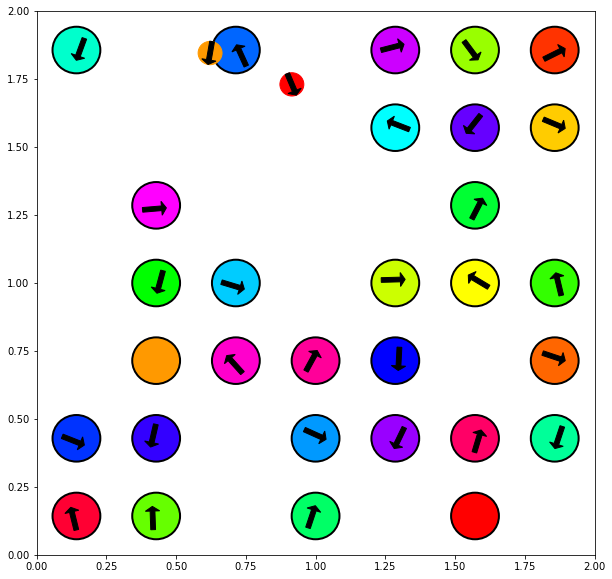

In [7]:
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    collided, done, gifs = infer(env, bnn)
    save_gif(gifs, 'gifs/dubins_no_obstacle/30_'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+'.gif')
    collideds.append(np.any(collided))
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

20it [01:51,  5.56s/it]

0.25 1.0 107.35


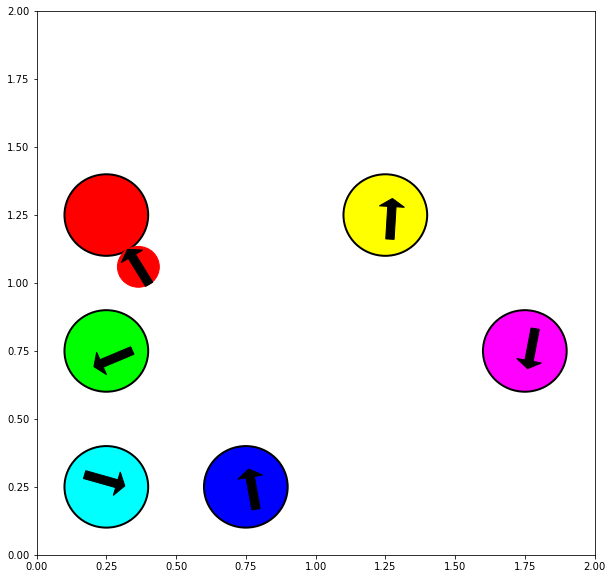

In [53]:
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    collided, done, gifs = infer(env, bnn)
    save_gif(gifs, 'gifs/dubins_no_obstacle/6_'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+'.gif')
    collideds.append(np.any(collided))
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

[0.09693839 0.11823238 0.16058196] [0.18836911 0.20503487 0.21482612] [0.18836911 0.20503487 0.18863697] [False False False]
[0.09139033 0.12640543 0.15829368] [0.18285777 0.21308906 0.21209855] [0.1500084  0.18206574 0.18574776] [False False False]
[0.07698978 0.12354822 0.15150912] [0.1683485  0.21014322 0.20628448] [0.1229832  0.16747393 0.17918964] [False False False]
[0.06304915 0.12065531 0.1410047 ] [0.15431504 0.20683809 0.19783373] [0.10876338 0.16363187 0.16709311] [False False False]
[0.04968013 0.11460699 0.12802579] [0.1391793  0.20056845 0.18752737] [0.09464507 0.15774168 0.1545545 ] [False False False]
[0.03480868 0.10697319 0.11051323] [0.13028882 0.19530953 0.16537859] [0.08221383 0.15171488 0.13457628] [False False False]
[0.02897353 0.09967561 0.08649133] [0.12450032 0.18794484 0.14209963] [0.07690181 0.14415111 0.11031045] [False False False]
[0.01876448 0.09005792 0.06113432] [0.11448993 0.177817   0.12038578] [0.06644593 0.13467892 0.0849375 ] [False False False]


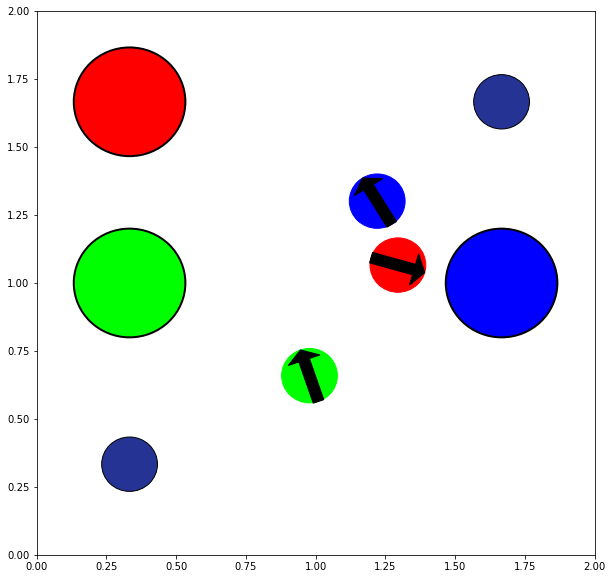

In [33]:
env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(valid_dataset[0])
collided, done, gifs = infer(env, bnn, verbose=True)
save_gif(gifs, 'gifs/dubins/gg.gif')

# inference with potential field

In [13]:
NUM_AGENTS, OBSTACLE_DENSITY, MAP_SIZE = 30, 0, 7

In [15]:
Env = DubinsCarEnv
valid_dataset = []
for _ in range(20):
    while True:
        env = Env(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
        if (np.linalg.norm(env.world.agents - env.world.agent_goals, axis=-1).min() >= 2):
            break
    valid_dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

In [10]:
@torch.no_grad()
def infer_p(env, K1=1e-1, K2=-1e-2, verbose=False, seed=0, n_candidates=100):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    gifs = [env._render()]
    max_episode_length = 256
    total_trans=0; n_danger=0; threshold=THRESHOLD; no_feasible=0; collided=np.zeros(env.num_agents).astype(bool)

    while True:
        o = env._get_obs()
        a_all = np.random.uniform(-1, 1, size=(env.num_agents, n_candidates, env.action_dim))
        pvalues = env.potential_field(a_all, K1, K2)
        
        v = np.zeros(env.num_agents)
        a = np.zeros((env.num_agents, env.action_dim))
        for agent_id, a_refine, pvalue in zip(np.arange(env.num_agents), a_all, pvalues):
            a[agent_id] = a_refine[np.argmin(pvalue)]
            v[agent_id] = pvalue[np.argmin(pvalue)]

        next_o, rw, done, info = env.step(a)

        prev_danger = info['prev_danger'].data.cpu().numpy().astype(bool)
        next_danger = info['next_danger'].data.cpu().numpy().astype(bool)
        if np.any(next_danger):
            collided = collided | next_danger
        if verbose:
            print(pvalues.min(axis=-1), pvalues.max(axis=-1), v, next_danger)

        total_trans += 1
        gifs.append(env._render())

        if done or (total_trans >= max_episode_length):
            break

    return collided, done, gifs

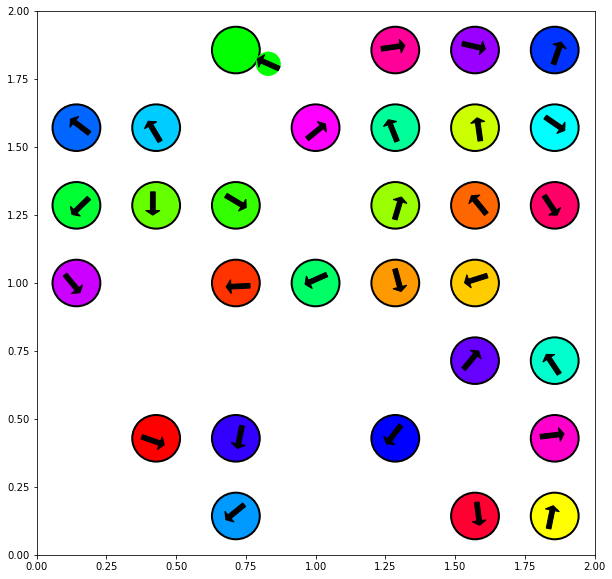

In [16]:
collideds = []
dones = []
for v_idx, data in enumerate(valid_dataset):
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    collided, done, gifs = infer_p(env)
    save_gif(gifs, 'gifs/potential_field/'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+'.gif')
    collideds.append(np.any(collided))
    dones.append(done)

In [17]:
np.mean(collideds)

0.2

In [24]:
np.mean(np.array(dones) & (~np.array(collideds)))

0.7

In [19]:
len(total_buffer)

NameError: name 'total_buffer' is not defined

ERROR! Session/line number was not unique in database. History logging moved to new session 337


In [454]:
len(cbuf.obs_buf)

103

In [392]:
total_buffer = np.array(total_buffer)
total_buffer_a = np.array(total_buffer_a)

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(total_buffer)
dists, idxs = nbrs.kneighbors(total_buffer, 10, return_distance=True)
best_idx = dists.mean(axis=-1).argmin()
random_data = total_buffer[best_idx]
dists, idxs = nbrs.kneighbors([random_data], 10, return_distance=True)
total_buffer_a[idxs], dists

# inference

In [ ]:
from gym_dubins_car import DubinsCarEnv
from stable_baselines3 import PPO
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Env = DubinsCarEnv
env = DubinsCarEnv(num_agents=3, mode='barrier', PROB=(0,0.1), SIZE=(8,8))
nominal_control = lambda x: np.clip(np.array([2, 0])-x, -1, 1)
name_dict = generate_default_model_name(Env)

bnn = DMLP(state_dim=Env.state_dim, action_dim=Env.action_dim, mode='straight')
CURRENT_BMODEL_PATH = name_dict['db'].replace('.pt', '_current.pt')
bnn.load_state_dict(torch.load(CURRENT_BMODEL_PATH, map_location=device))
bnn.to(device)
bnn.eval()

writer = SummaryWriter()
writer.step = 0
max_episode_length = 256
BATCH = 64
N_ITER = 1
N_EPOCH = 12000

### visualization on traj

<All keys matched successfully>
[0.0115147  0.01150848 0.01151653] [0.01357781 0.01361043 0.01357691] [0.01309946 0.01361043 0.01310479] [False, False, False]
[0.0115034  0.01151653 0.01152094] [0.01358335 0.01358335 0.01358335] [0.01309946 0.01247505 0.01227353] [False, False, False]
[0.01151146 0.0115034  0.0115147 ] [0.01358335 0.01358335 0.01357874] [0.01310614 0.01174829 0.01178436] [False, False, False]
[0.01151779 0.01152342 0.01151796] [0.01358335 0.01357691 0.01357874] [0.01309946 0.01176712 0.01176607] [False, False, False]
[0.0115034  0.01151653 0.01152191] [0.01358335 0.01357691 0.01357874] [0.01309141 0.0117482  0.01174453] [False, False, False]
[0.01152267 0.01152094 0.01151443] [0.01357381 0.01357874 0.01357874] [0.01233564 0.01177931 0.01176931] [False, False, False]
[0.0115207  0.01152191 0.01151824] [0.01357781 0.01357874 0.01358335] [0.01178591 0.01177413 0.01175363] [False, False, False]
[0.01151914 0.01426083 0.0111011 ] [0.01358335 0.01756666 0.01635711] [0.011771

AssertionError: 

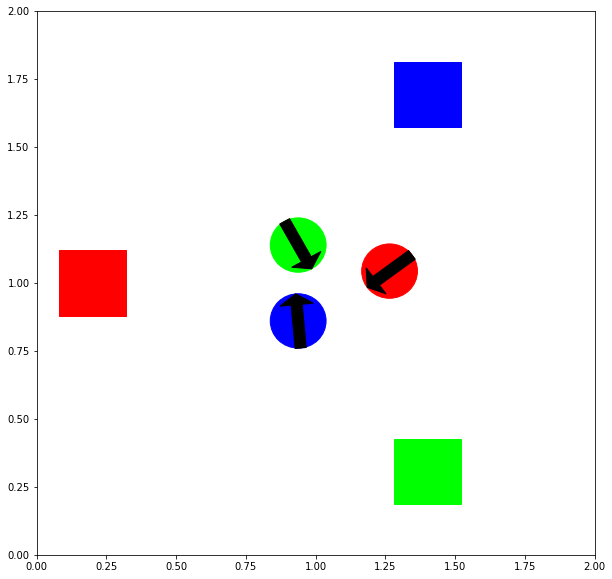

In [72]:
NUM_AGENTS = 3
MAP_SIZE = 5
OBSTACLE_DENSITY = 0.
THRESHOLD = 1e-2

from gym_dubins_car import DubinsCarEnv
from tqdm import tqdm
from collections import defaultdict
from PIL import Image
import random

bnn = DBarrierGNN(state_dim=Env.state_dim, action_dim=Env.action_dim)
bnn.to(device)

name_dict = generate_default_model_name(Env)
print(bnn.load_state_dict(torch.load(name_dict['db'], map_location=device)))  # .replace('.pt', '_current.pt')
bnn.eval()

Env = DubinsCarEnv
env = DubinsCarEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))

def infer(env, verbose=True, seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)    
    
    max_episode_length = 256

    total_trans=0; n_danger=0; threshold=THRESHOLD; no_feasible=0; collided=np.zeros(env.num_agents).astype(bool);gifs = [env._render()]

    while True:
        o = env._get_obs()
        a_all = np.random.uniform(-1, 1, size=(env.num_agents, n_candidates, env.action_dim))
        a_refines, bvalues = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)

        dists = []
        next_states = np.tile(env.world.agents.reshape(env.num_agents, 1, -1), (1, n_candidates, 1))
        ax, ay, theta = next_states[:, :, 0], next_states[:, :, 1], next_states[:, :, 2]
        theta = theta + 0.6*a_refines.squeeze(-1)
        dx, dy = 0.05*np.cos(theta), 0.05*np.sin(theta)
        next_states[:, :, 0] = ax + dx
        next_states[:, :, 1] = ay + dy
        theta = theta + (theta - 2* np.pi)*(theta>np.pi) + (theta + 2* np.pi)*(theta<-np.pi)
        next_states[:, :, 2] = theta
        
        dists = np.linalg.norm((next_states-env.world.agent_goals.reshape(env.num_agents, 1, -1))[:,:,:2], axis=-1)
        a = np.zeros((env.num_agents, env.action_dim))
        v = np.zeros(env.num_agents)
        for agent_id, a_refine, bvalue, dist in zip(np.arange(env.num_agents), a_refines, bvalues, dists):
            if np.any(bvalue>threshold):
                for a_idx in np.argsort(dist):
                    if bvalue[a_idx] > threshold:
                        a[agent_id] = a_refine[a_idx]
                        v[agent_id] = bvalue[a_idx]
                        break
            else:
                no_feasible += 1
                a[agent_id] = a_refine[np.argmax(bvalue)]
                v[agent_id] = bvalue[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)

        prev_danger = info['prev_danger']
        next_danger = info['next_danger']
        if np.any(next_danger):
            collided = collided | info['next_danger']
        if verbose:
            print(bvalues.min(axis=-1), bvalues.max(axis=-1), v, info['next_danger'])

        total_trans += 1
        gifs.append(env._render())
        
        if no_feasible:
            assert False

        if done or (total_trans >= max_episode_length):
            break
            
    return gifs, collided, done

def save_gif(gifs, name="play.gif"):
    a_frames = []
    for img in gifs:
        a_frames.append(np.asarray(img))
    a_frames = np.stack(a_frames)

    ims = [Image.fromarray(a_frame) for a_frame in a_frames]
    ims[0].save(name, save_all=True, append_images=ims[1:], loop=0, duration=10)

env = DubinsCarEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
half_size = MAP_SIZE / 2
env.world.agents = np.array([[half_size+(half_size-0.5)*np.cos(a), half_size+(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
env.world.agent_goals = np.array([[half_size-(half_size-0.5)*np.cos(a), half_size-(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
gifs, collided, done = infer(env)
save_gif(gifs)
collided

array([False, False, False, False, False, False])

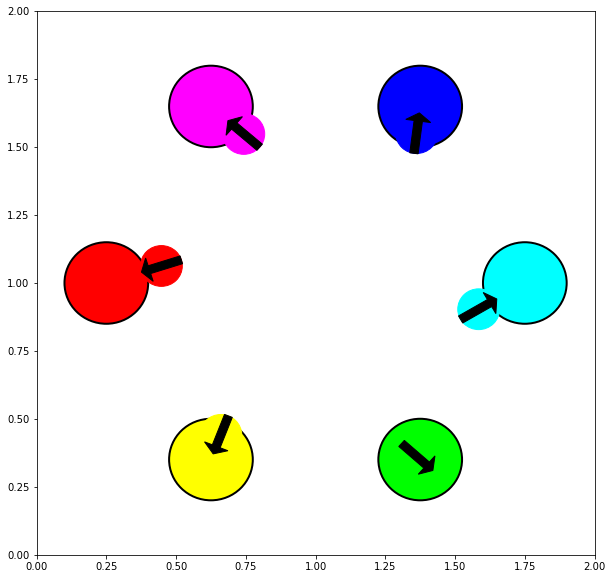

In [28]:
env = DubinsCarEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
half_size = MAP_SIZE / 2
env.world.agents = np.array([[half_size+(half_size-0.5)*np.cos(a), half_size+(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
env.world.agent_goals = np.array([[half_size-(half_size-0.5)*np.cos(a), half_size-(half_size-0.5)*np.sin(a)]+[0.]*(Env.state_dim-2) for a in np.linspace(0, 2*np.pi, NUM_AGENTS, endpoint=False)])
collided, done, gifs = infer(env, bnn)
save_gif(gifs, 'gifs/dubins/play.gif')
collided

In [27]:
NUM_AGENTS, OBSTACLE_DENSITY, MAP_SIZE = (6, 0, 4)

In [31]:
from tqdm import tqdm
from copy import deepcopy

NUM_AGENTS = 6
MAP_SIZE = 3
OBSTACLE_DENSITY = 0.

# generate training data
dataset = []
for _ in tqdm(range(100)):
    env = DubinsCarEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
    dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

100%|██████████| 100/100 [00:00<00:00, 8074.67it/s]


100%|██████████| 100/100 [06:25<00:00,  3.86s/it]


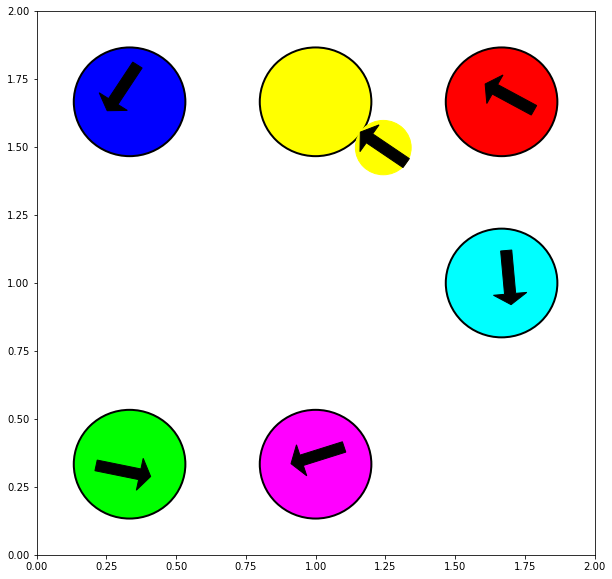

In [32]:
collides = 0
lengths = 0
for idx, problem in tqdm(list(zip(range(len(dataset)), dataset))):
    env = DubinsCarEnv(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(problem)
    collided, done, gifs = infer(env, bnn, verbose=False)
    collides += np.any(collided)
    lengths += len(gifs)
    save_gif(gifs, 'gifs/dubins/'+str(idx)+'.gif')

In [19]:
env._get_obs(loop=True)

AssertionError: 

### visualization on CBF

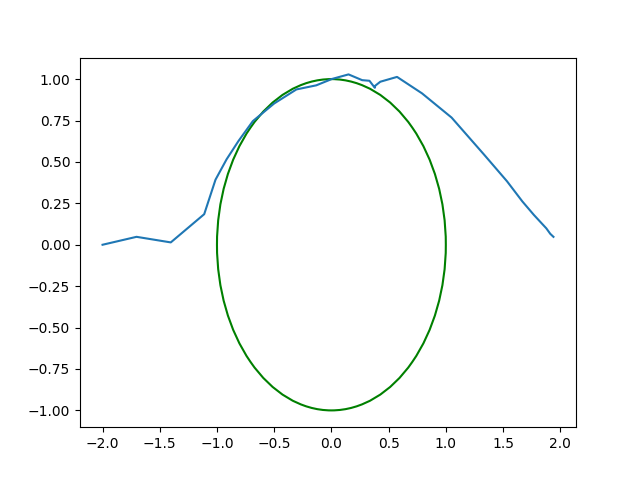

In [30]:
%matplotlib widget
import ipympl
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
fig, ax = plt.subplots()
plt.plot(*np.array(trajs[24]).T)
c = plt.Circle((0, 0), 1, edgecolor='g', facecolor='white', clip_on=False, linewidth=1.5)
ax.add_patch(c)
plt.show()

In [59]:
bnn(x=torch.FloatTensor(np.array(trajs[99])[:-1]).to(device), action=torch.FloatTensor(np.array(trajs[99])[1:,]-np.array(trajs[99])[:-1]).to(device)/0.3).data.cpu().numpy()

array([ 0.00615322,  0.0168369 ,  0.02461939,  0.03725697, -0.04950445,
        0.04675311, -0.01833821,  0.03422268,  0.08368017,  0.09180238,
        0.20361288,  0.3725643 ,  0.5286677 ,  0.6686999 ,  0.7717982 ,
        0.8585829 ,  0.907426  ,  0.94885206,  0.979881  ], dtype=float32)

In [42]:
trajs[59][1]

array([-1.73082578, -0.24192397])

In [133]:
bnn(x=torch.FloatTensor([-1.1, 0]).to(device), action=torch.FloatTensor([0.4, 0]).to(device))

tensor(0.0157, device='cuda:0', grad_fn=<SqueezeBackward1>)

### G

In [37]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 1000
env.reset()
#     env.world.agents = env.world.sample_agents(env.num_agents, prob=0.0)
total_trans=0; n_danger=0; threshold=1e-2

while True:
    o = env._get_obs()
    a_best = nominal_control(o)
    a_other = np.random.uniform(-1., 1., size=(n_candidates-1, env.action_dim))
    a_all = np.zeros((n_candidates, env.action_dim))
    a_all[0, :] = a_best
    a_all[1:, :] = a_other

    o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
    a_refine, bvalue = iter_action(bnn, o, a_other, max_iter=0, threshold=threshold)

    a, a_value = choose_action(a_refine, bvalue, threshold=threshold, explore_eps=0., nominal_eps=0.)

    next_o, rw, done, info = env.step(a_best)
    # if info['next_danger']:
    print(o['x'], a_value)
    n_collide += info['next_danger']

    threshold = 1e-2
    total_trans += 1
    n_danger += np.array(next_danger).sum()

    if done or (total_trans >= max_episode_length):
        n_reach += info['next_goal']
        break

tensor([-2.,  0.]) -0.13107894
tensor([-1.7000,  0.0000]) -0.122936025
tensor([-1.4000,  0.0000]) -0.11164804
tensor([-1.1000,  0.0000]) -0.10055794
tensor([-0.8000,  0.0000]) -0.09046771
tensor([-0.5000,  0.0000]) -0.082239956
tensor([-0.2000,  0.0000]) -0.0731955
tensor([0.1000, 0.0000]) -0.06821193
tensor([0.4000, 0.0000]) -0.07327388
tensor([0.7000, 0.0000]) -0.06384854
tensor([1., 0.]) -0.07175657
tensor([1.3000, 0.0000]) -0.08446115
tensor([1.5100, 0.0000]) -0.08590387
tensor([1.6570, 0.0000]) -0.079477355
tensor([1.7599, 0.0000]) -0.095163316
tensor([1.8319, 0.0000]) -0.08545959
tensor([1.8824, 0.0000]) -0.08211541


# benchmark

In [31]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 100

for _ in tqdm(range(N_TEST)):
    
    infer_traj = [env.reset()]
    total_trans=0; n_danger=0; threshold=2e-2; collided=False
    env.state = env.state + np.random.uniform(-5e-2, 5e-2, size=(2,))

    while True:
        o = env._get_obs()
        a_all = np.hstack([i.reshape(-1, 1) for i in np.meshgrid(*([np.linspace(-1, 1, 20)]*2))])  #np.random.uniform(-1, 1, size=(n_candidates, env.action_dim))

        o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
        a_refine, bvalue = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)

        dists = []
        for a in a_refine:
            next_state = a + env.state
            dists.append(np.linalg.norm(next_state-np.array([2, 0])))
        if np.any(bvalue>threshold):
            for a_idx in np.argsort(dists):
                if bvalue[a_idx] > threshold:
                    a = a_refine[a_idx]
                    break
        else:
            a = a_refine[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)
        infer_traj.append(env.state.copy())
        # if info['next_danger']:
        # print(bvalue[0], bvalue.min(), bvalue.max(), threshold, a_value, 'TRUE' if info['next_danger'] else '')
        if info['next_danger']:
            collided = True
        
        total_trans += 1
        n_danger += np.array(next_danger).sum()

        if done or (total_trans >= max_episode_length):
            n_collide += collided
            n_reach += info['next_goal']
            break

100%|██████████| 100/100 [00:04<00:00, 21.83it/s]


In [32]:
n_collide

0

In [33]:
n_reach

100